# Ovrlpy analysis tutorial of Xenium mouse brain data

In this notebook, we will use ovrlpy to investigate the [Xenium's mouse brain dataset](https://www.10xgenomics.com/products/xenium-in-situ/mouse-brain-dataset-explorer).

We want to create a signal embedding of the transcriptome, and a vertical signal incoherence map to identify locations with a high risk of containing spatial doublets.


## Loading the data:

in a first step, we want to load the data and define settings and input files

In [45]:
from pathlib import Path

data_folder_path = Path(
    "/dh-projects/ag-ishaque/raw_data/tiesmeys-ovrlpy/Xenium-brain-2024/replicate1"
)

signature_matrix_file = Path(
    "/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv"
)

result_folder = Path("results")
result_folder.mkdir(exist_ok=True, parents=True)

Import relevant analysis packages

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ovrlpy

Set the random seed for reproducibility

In [47]:
import random

random.seed(42)

/tmp/ipykernel_2917984/1253206155.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinate_df["gene"] = coordinate_df["gene"].astype("category")


x            y          z     gene  cell_id  overlaps_nucleus  \
0  4843.045898  6427.729980  19.068869  Bhlhe40    67490                 1   
1  4844.632812  6223.182617  18.520161    Parm1    67957                 0   
2  4842.943359  6478.310547  18.500109  Bhlhe40    67539                 1   
3  4843.941406  6344.550293  15.016154     Lyz2    68003                 0   
4  4843.162598  6632.111816  15.394680     Dkk3    67344                 0   

          qv  
0  40.000000  
1  40.000000  
2  13.813585  
3  19.471884  
4  40.000000

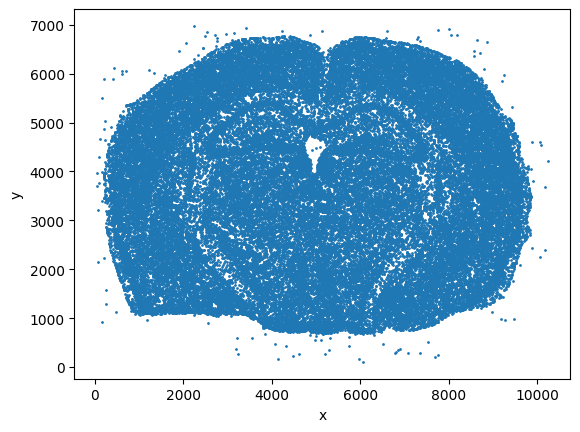

In [49]:
columns = [
    "x_location",
    "y_location",
    "z_location",
    "feature_name",
    "cell_id",
    "overlaps_nucleus",
    "qv",
]

coordinate_df = pd.read_parquet(
    data_folder_path / "transcripts.parquet", columns=columns
).rename(
    columns={
        "x_location": "x",
        "y_location": "y",
        "z_location": "z",
        "feature_name": "gene",
    }
)
coordinate_df["gene"] = coordinate_df["gene"].str.decode("utf-8")


# remove dummy molecules
coordinate_df = coordinate_df.loc[
    ~coordinate_df["gene"].str.contains("BLANK|NegControl"),
]

coordinate_df["gene"] = coordinate_df["gene"].astype("category")

coordinate_df[::1000].plot.scatter(x="x", y="y", s=1)

coordinate_df = coordinate_df.copy()  # make a copy to avoid SettingWithCopyWarning

coordinate_df.head()

#### Running the ovrlpy pipeline:

ovrlpy provides a convenience function `run` to run the entire pipeline. 
The function creates a signal integrity map, a signal strength map and a Visualizer obejcet to visualize the results.

In [51]:
signal_integrity, signal_strength, visualizer = ovrlpy.run(
    df=coordinate_df, cell_diameter=10, n_expected_celltypes=30
)

Running vertical adjustment
Creating gene expression embeddings for visualization:
Analyzing in 3d mode:
determining pseudocells:
found 62341 pseudocells
sampling expression:


Zfp536: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:43<00:00,  2.41it/s]


Modeling 30 pseudo-celltype clusters


/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/conda-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/conda-env/lib/python3.12/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Creating signal integrity map:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [11:04<00:00,  9.49s/it]


The visualizer object has a plotting method to show the embeddings of the sampled gene expression signal:

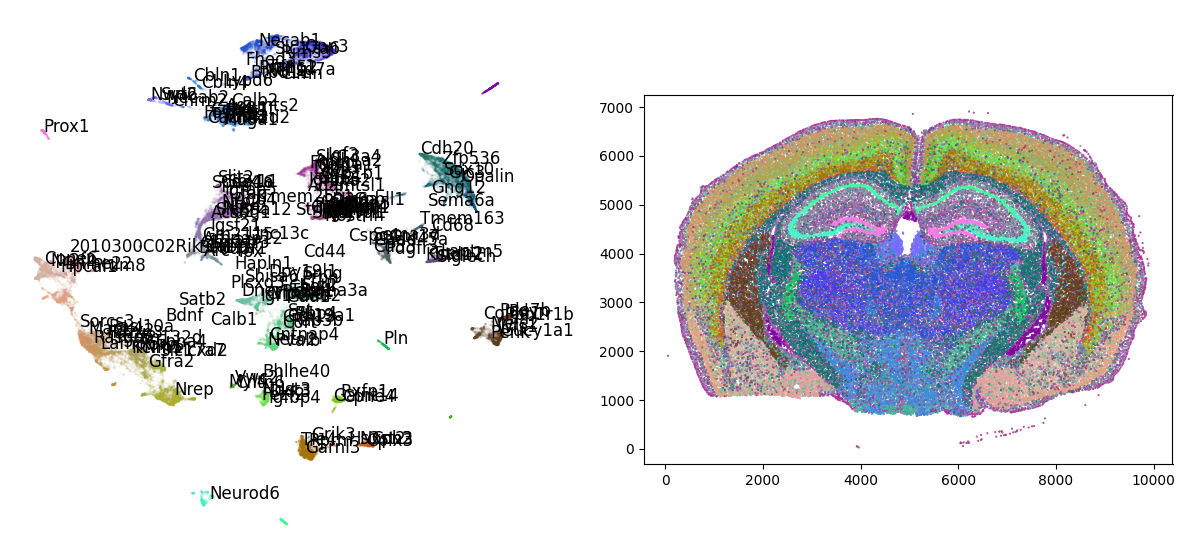

In [52]:
visualizer.plot_fit()

We can annotate the UMAP using external, single-cell derived cell type signatures to help interpret the cell type clusters in the gene-expression embedding:

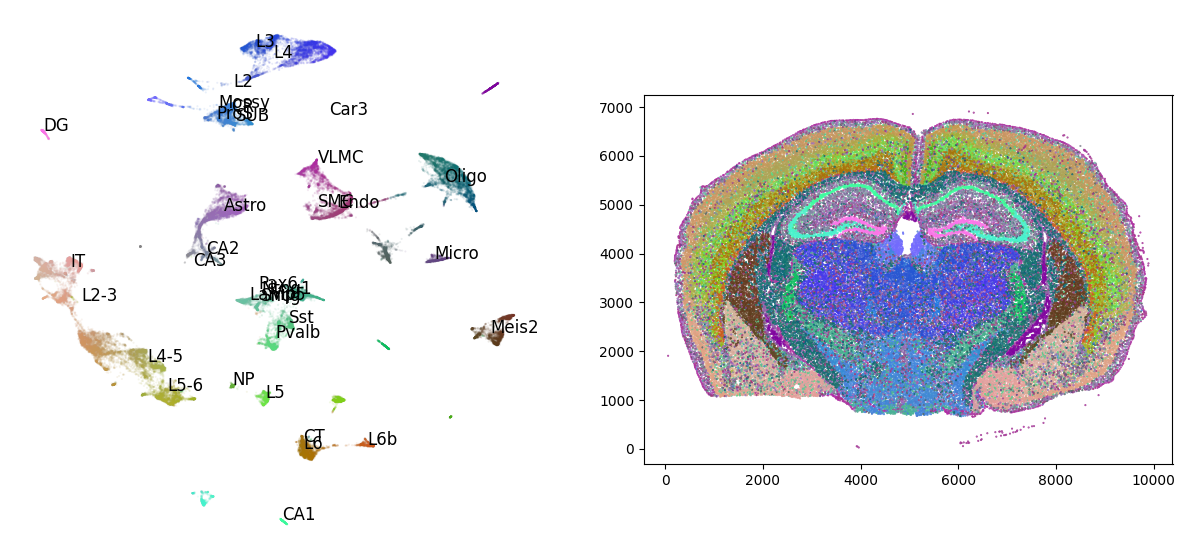

In [53]:
signatures = pd.read_csv(signature_matrix_file, index_col=0)

signatures = (
    signatures.T.groupby(lambda x: x.split("_")[1].split(" ")[0].split("-")[0])
    .apply(lambda x: x.mean(0))
    .T
).loc[signatures.index[signatures.index.isin(visualizer.genes)]]


signatures.columns = signatures.columns.str.replace("/", "-")

visualizer.fit_signatures(signatures)

visualizer.plot_fit()

In the same way, the signal integrity map can be visualized, where visualization is cut off at regions below a certain signal strength threshold:

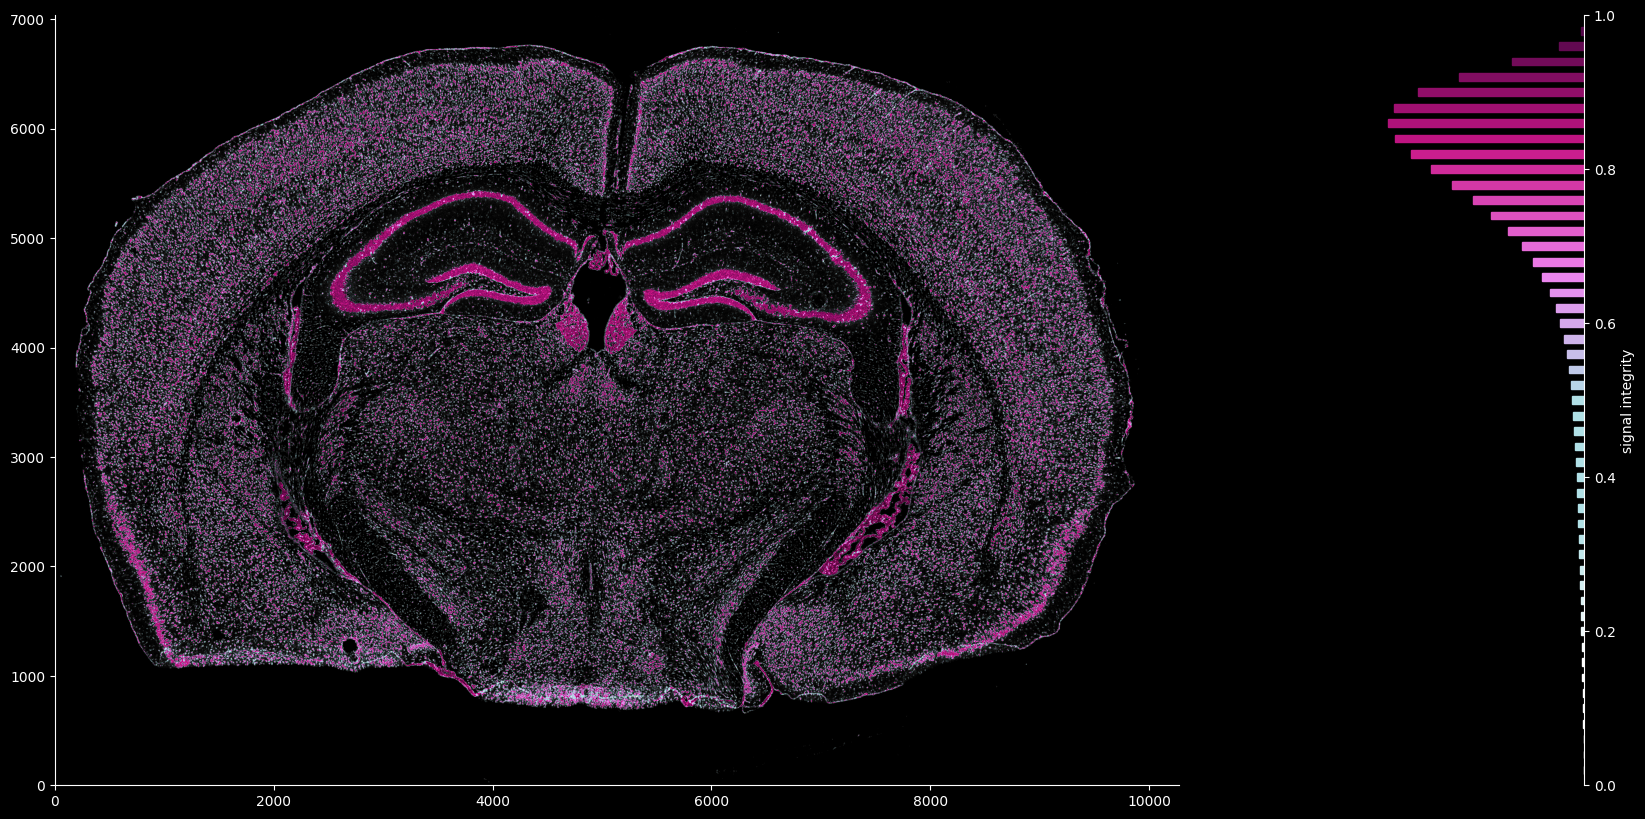

In [56]:
fig, ax = ovrlpy.plot_signal_integrity(
    signal_integrity, signal_strength, signal_threshold=3
)

We can detect individual doublet events with ovrlpy, again setting a signal strength threshold to filter out low-transcript regions:

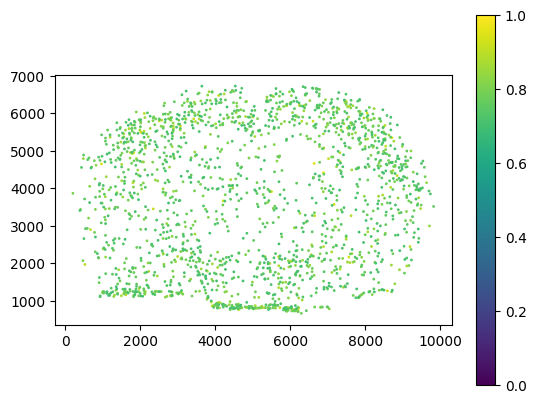

In [63]:
doublet_df = ovrlpy.detect_doublets(
    signal_integrity, signal_strength, minimum_signal_strength=3, integrity_sigma=2
)

_ = plt.scatter(
    doublet_df["x"],
    doublet_df["y"],
    c=doublet_df["integrity"],
    s=1,
    cmap="viridis",
    vmin=0,
    vmax=1,
)
plt.gca().set_aspect("equal")
plt.colorbar()

Having sampled regions of potential doublets, we can visualize them as close-up transcriptome molecule clouds through the Visualizer's learned color embeddings - by providing their (x,y) locations to `ovrlpy.plot_region_of_interest`:

/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/conda-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


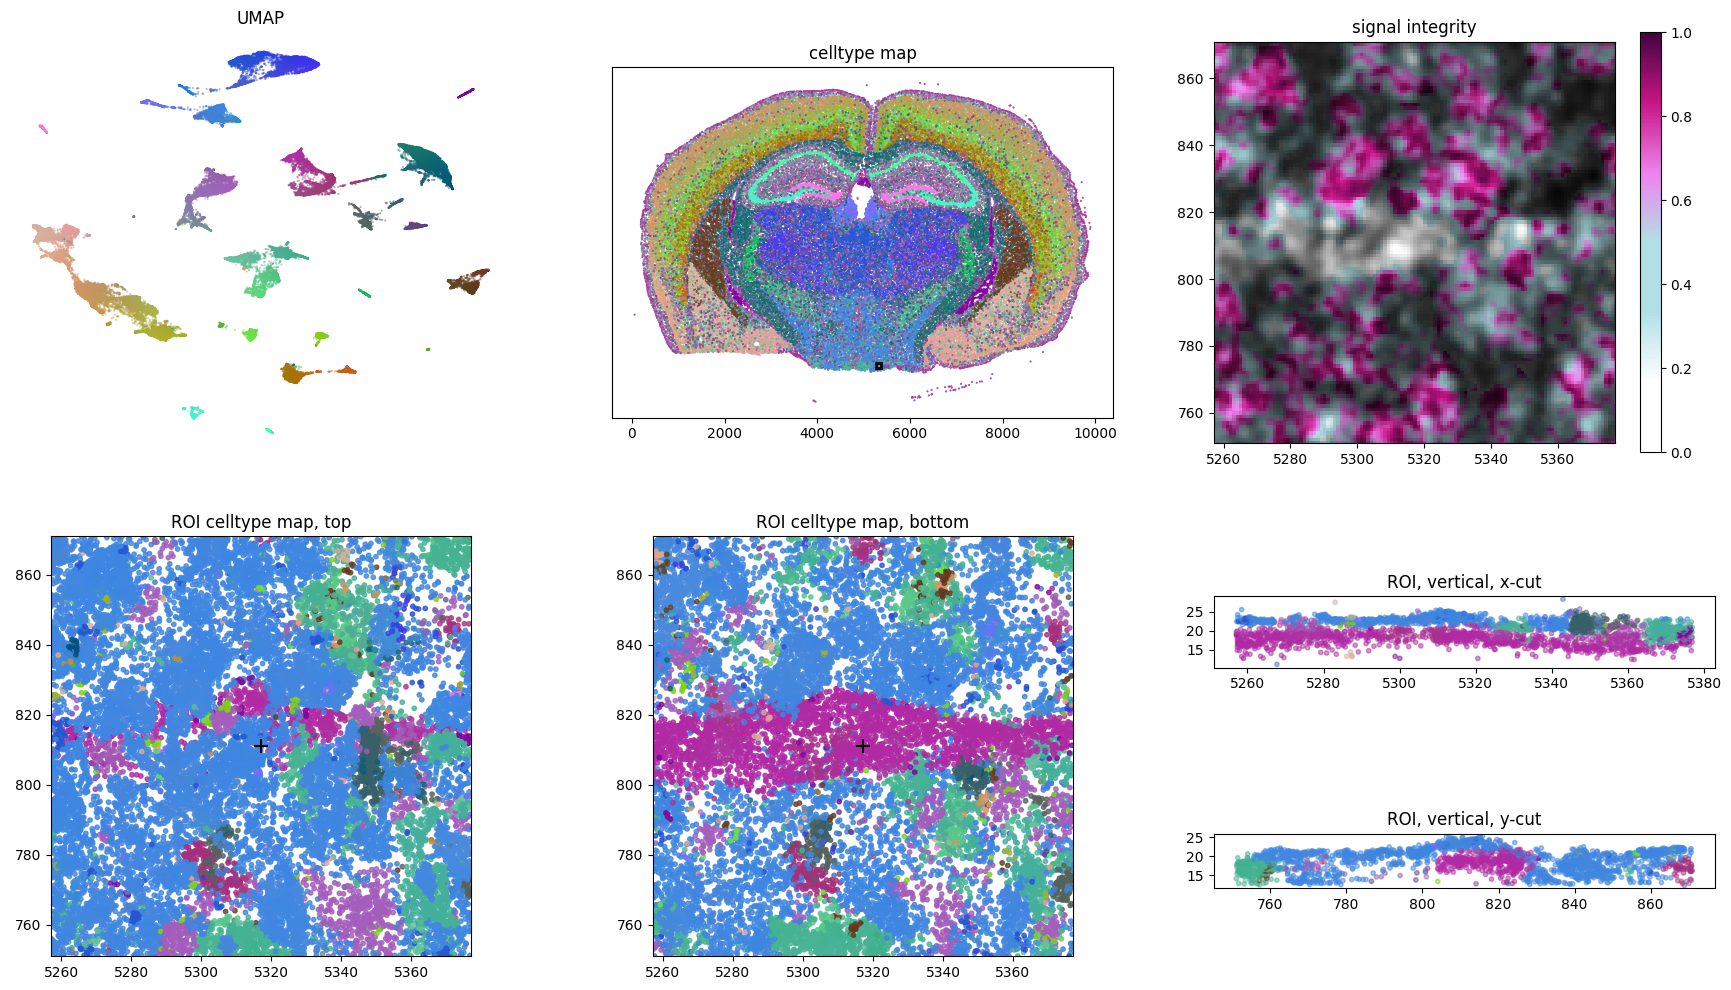

In [64]:
window_size = 60
doublet_case = 0

x, y = doublet_df.loc[doublet_case, ["x", "y"]]

ovrlpy.plot_region_of_interest(
    x,
    y,
    coordinate_df,
    visualizer,
    signal_integrity,
    signal_strength,
    window_size=window_size,
)

Furthermore, we can save the visualizer object to file for later use ...

In [65]:
visualizer.save(result_folder / "Xenium-text-visualizer.vis")

/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/conda-env/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


... and easily reload it if needed.

In [69]:
vis = ovrlpy.load_visualizer(result_folder / "Xenium-text-visualizer.vis")

Additionally, the analysis has produced a global z-level adjustment of the transcriptome coordinates, which can be used to create a z-stack of adjacent, aligned sections in silico:

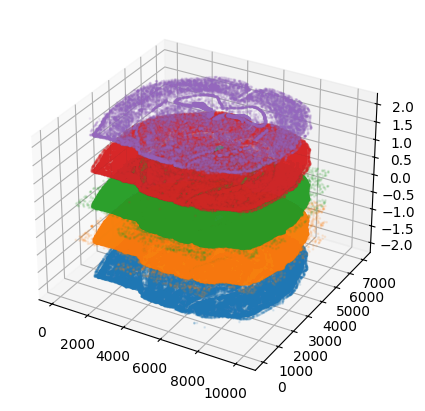

In [70]:
plt.figure(figsize=(20, 5))

ax = plt.subplot(111, projection="3d")

for i in range(-2, 3):
    subset = coordinate_df[(coordinate_df.z - coordinate_df.z_delim).between(i, i + 1)]

    ax.scatter(
        subset.x[::100],
        subset.y[::100],
        np.zeros(1 + (len(subset) // 100)) + i,
        s=1,
        alpha=0.1,
    )